# 1. Imports packages

In [6]:
from scipy.stats import norm
from scipy.stats import t
import numpy as np
import pandas as pd
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set()

# 2. Load Data

In [8]:
df_train = pd.read_csv("../house-prices-advanced-regression-techniques/train.csv")

In [9]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# 3. EDA - SalePrice

`SalePrice` is what we are going to predict, therefore, it's the most important feature, so I'm gogin to analyze it deeper.

In [11]:
df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

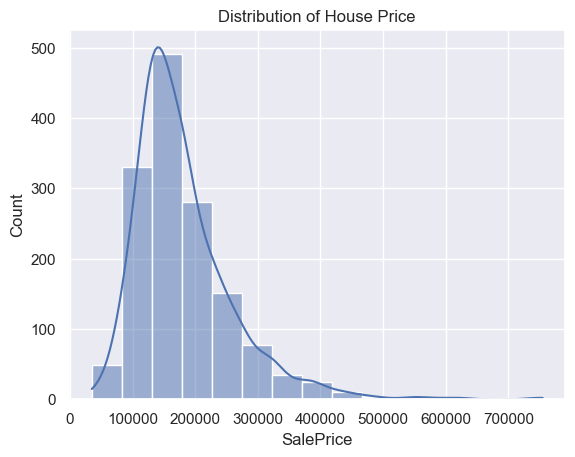

In [12]:
fig, ax = plt.subplots()
sns.histplot(df_train['SalePrice'], kde=True, bins=15)
sns.set_style('whitegrid')
ax.set(title='Distribution of House Price')
plt.show()

- Average house sale price is around `$180,000` in Ames.
- There are a few properties over `$500,000`, but majority of houses are priced under `$214,000`.

### Feature Correlation Heatmap

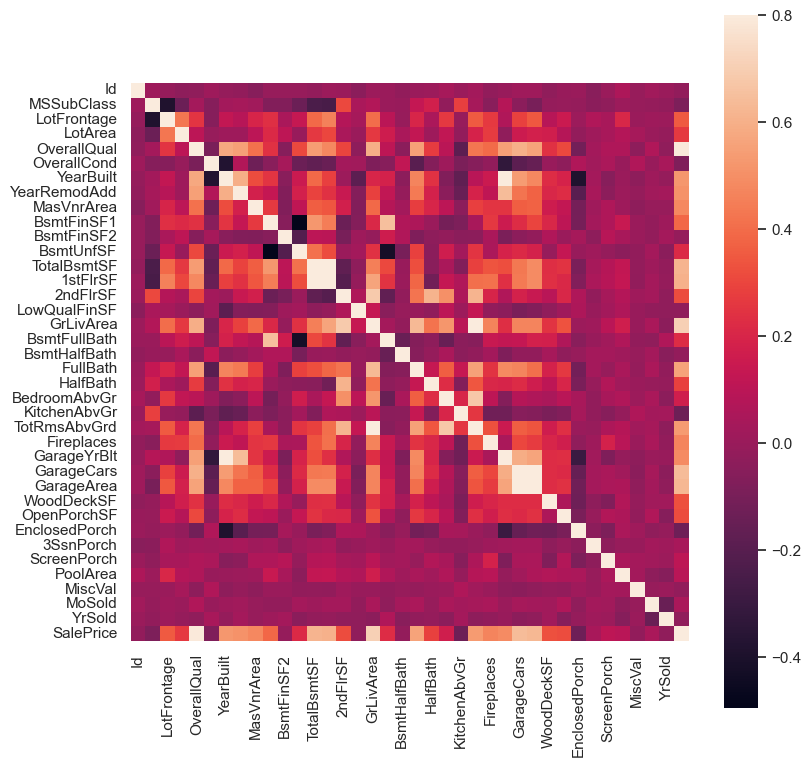

In [13]:
# To gain a high level view of relationships amongst the features
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


There are several squares that get my attention. The first one refers to the `TotalBsmtSF` and `1stFlrSF` variables, and the second one refers to the `GarageX` variables. Both cases show how significant the correlation is between these variables. The correlation is so strong that it can indicate a situation of multicollinearity. If we think about these variables, we can conclude that they give almost the same information so multicollinearity really occurs. 

Another thing that got my attention was the `SalePrice` correlations. We can see our well-known `GrLivArea`, `TotalBsmtSF`, and `OverallQual` are highly correlated, but we can also see many other variables that should be taken into account. 

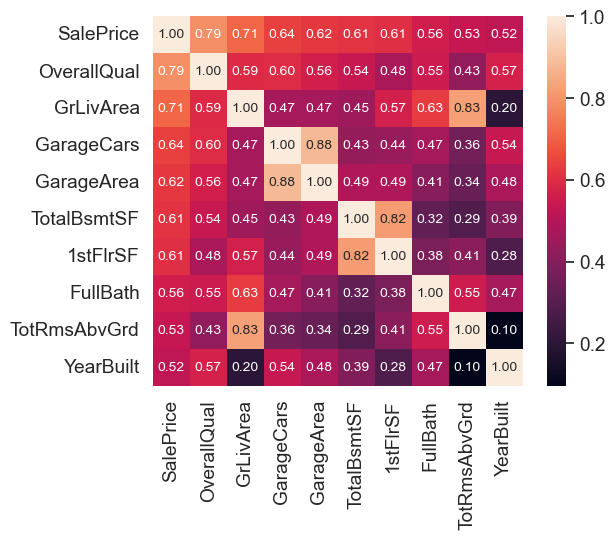

In [14]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

These are the variables most correlated with 'SalePrice':

- `OverallQual`, `GrLivArea` and `TotalBsmtSF` are strongly correlated with `SalePrice`. 

- `GarageCars` and `GarageArea` are also some of the most strongly correlated variables. However, in the previous plot, those two features are multicollinearity, so we just need to consider the one that has higher correlation with `SalePrice` which is `GarageCars`.

- `TotalBsmtSF` and `1stFloor` also seem to be multicollinearity so will keep `TotalBsmtSF`. 

- `TotRmsAbvGrd` and `GrLivArea` are also multicollinearity so will not consider `TotRmsAbvGrd`. 

- `YearBuilt` is slightly correlated with `SalePrice`. I will plot a line plot related to year features.

### Top 10 Features Pairplot - See the relationship between each feature

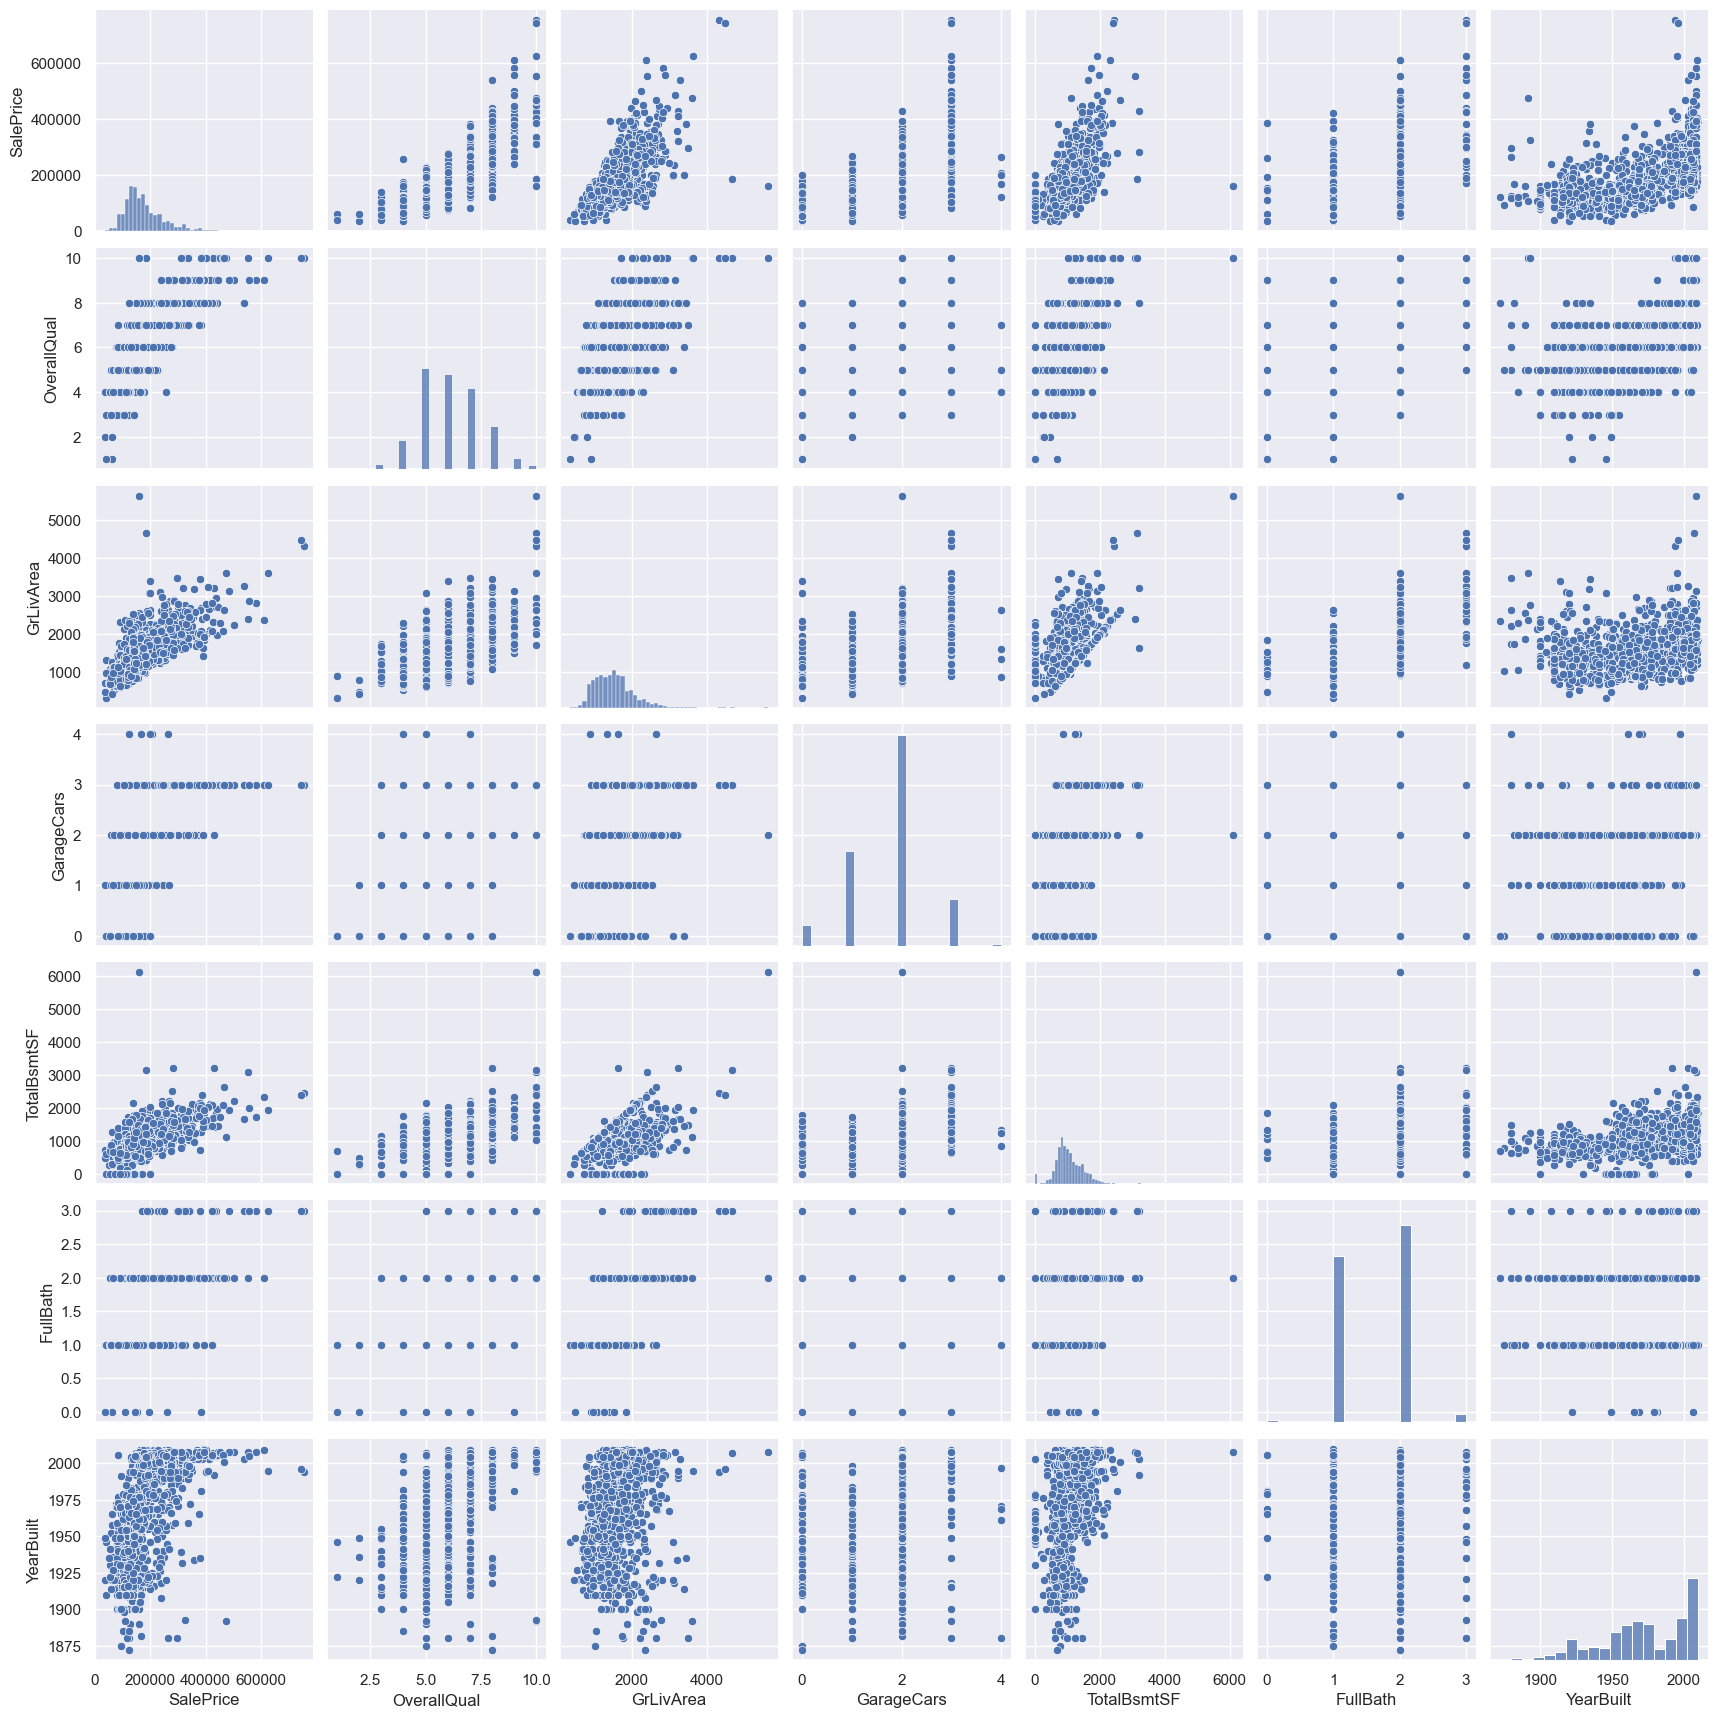

In [15]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height = 2.5)
plt.show();

One of the figures we may find interesting is the one between `TotalBsmtSF` and `GrLiveArea`. In this figure we can almost draw a linear line. It makes sense that the majority of the dots stay below that line. Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area.

### Scatterplots of Numeric Features Against Sale Price

In [16]:
# Define useful function to create scatterplots of sale prices against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        sns.histplot(df_train['SalePrice'], kde=True)
        ax.scatter(x = col, y = 'SalePrice', data=df_train, alpha=0.5)
        ax.set(xlabel=col, ylabel='Sale price')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [17]:
features = [col for col in df_train.select_dtypes(exclude = ['object']).columns]

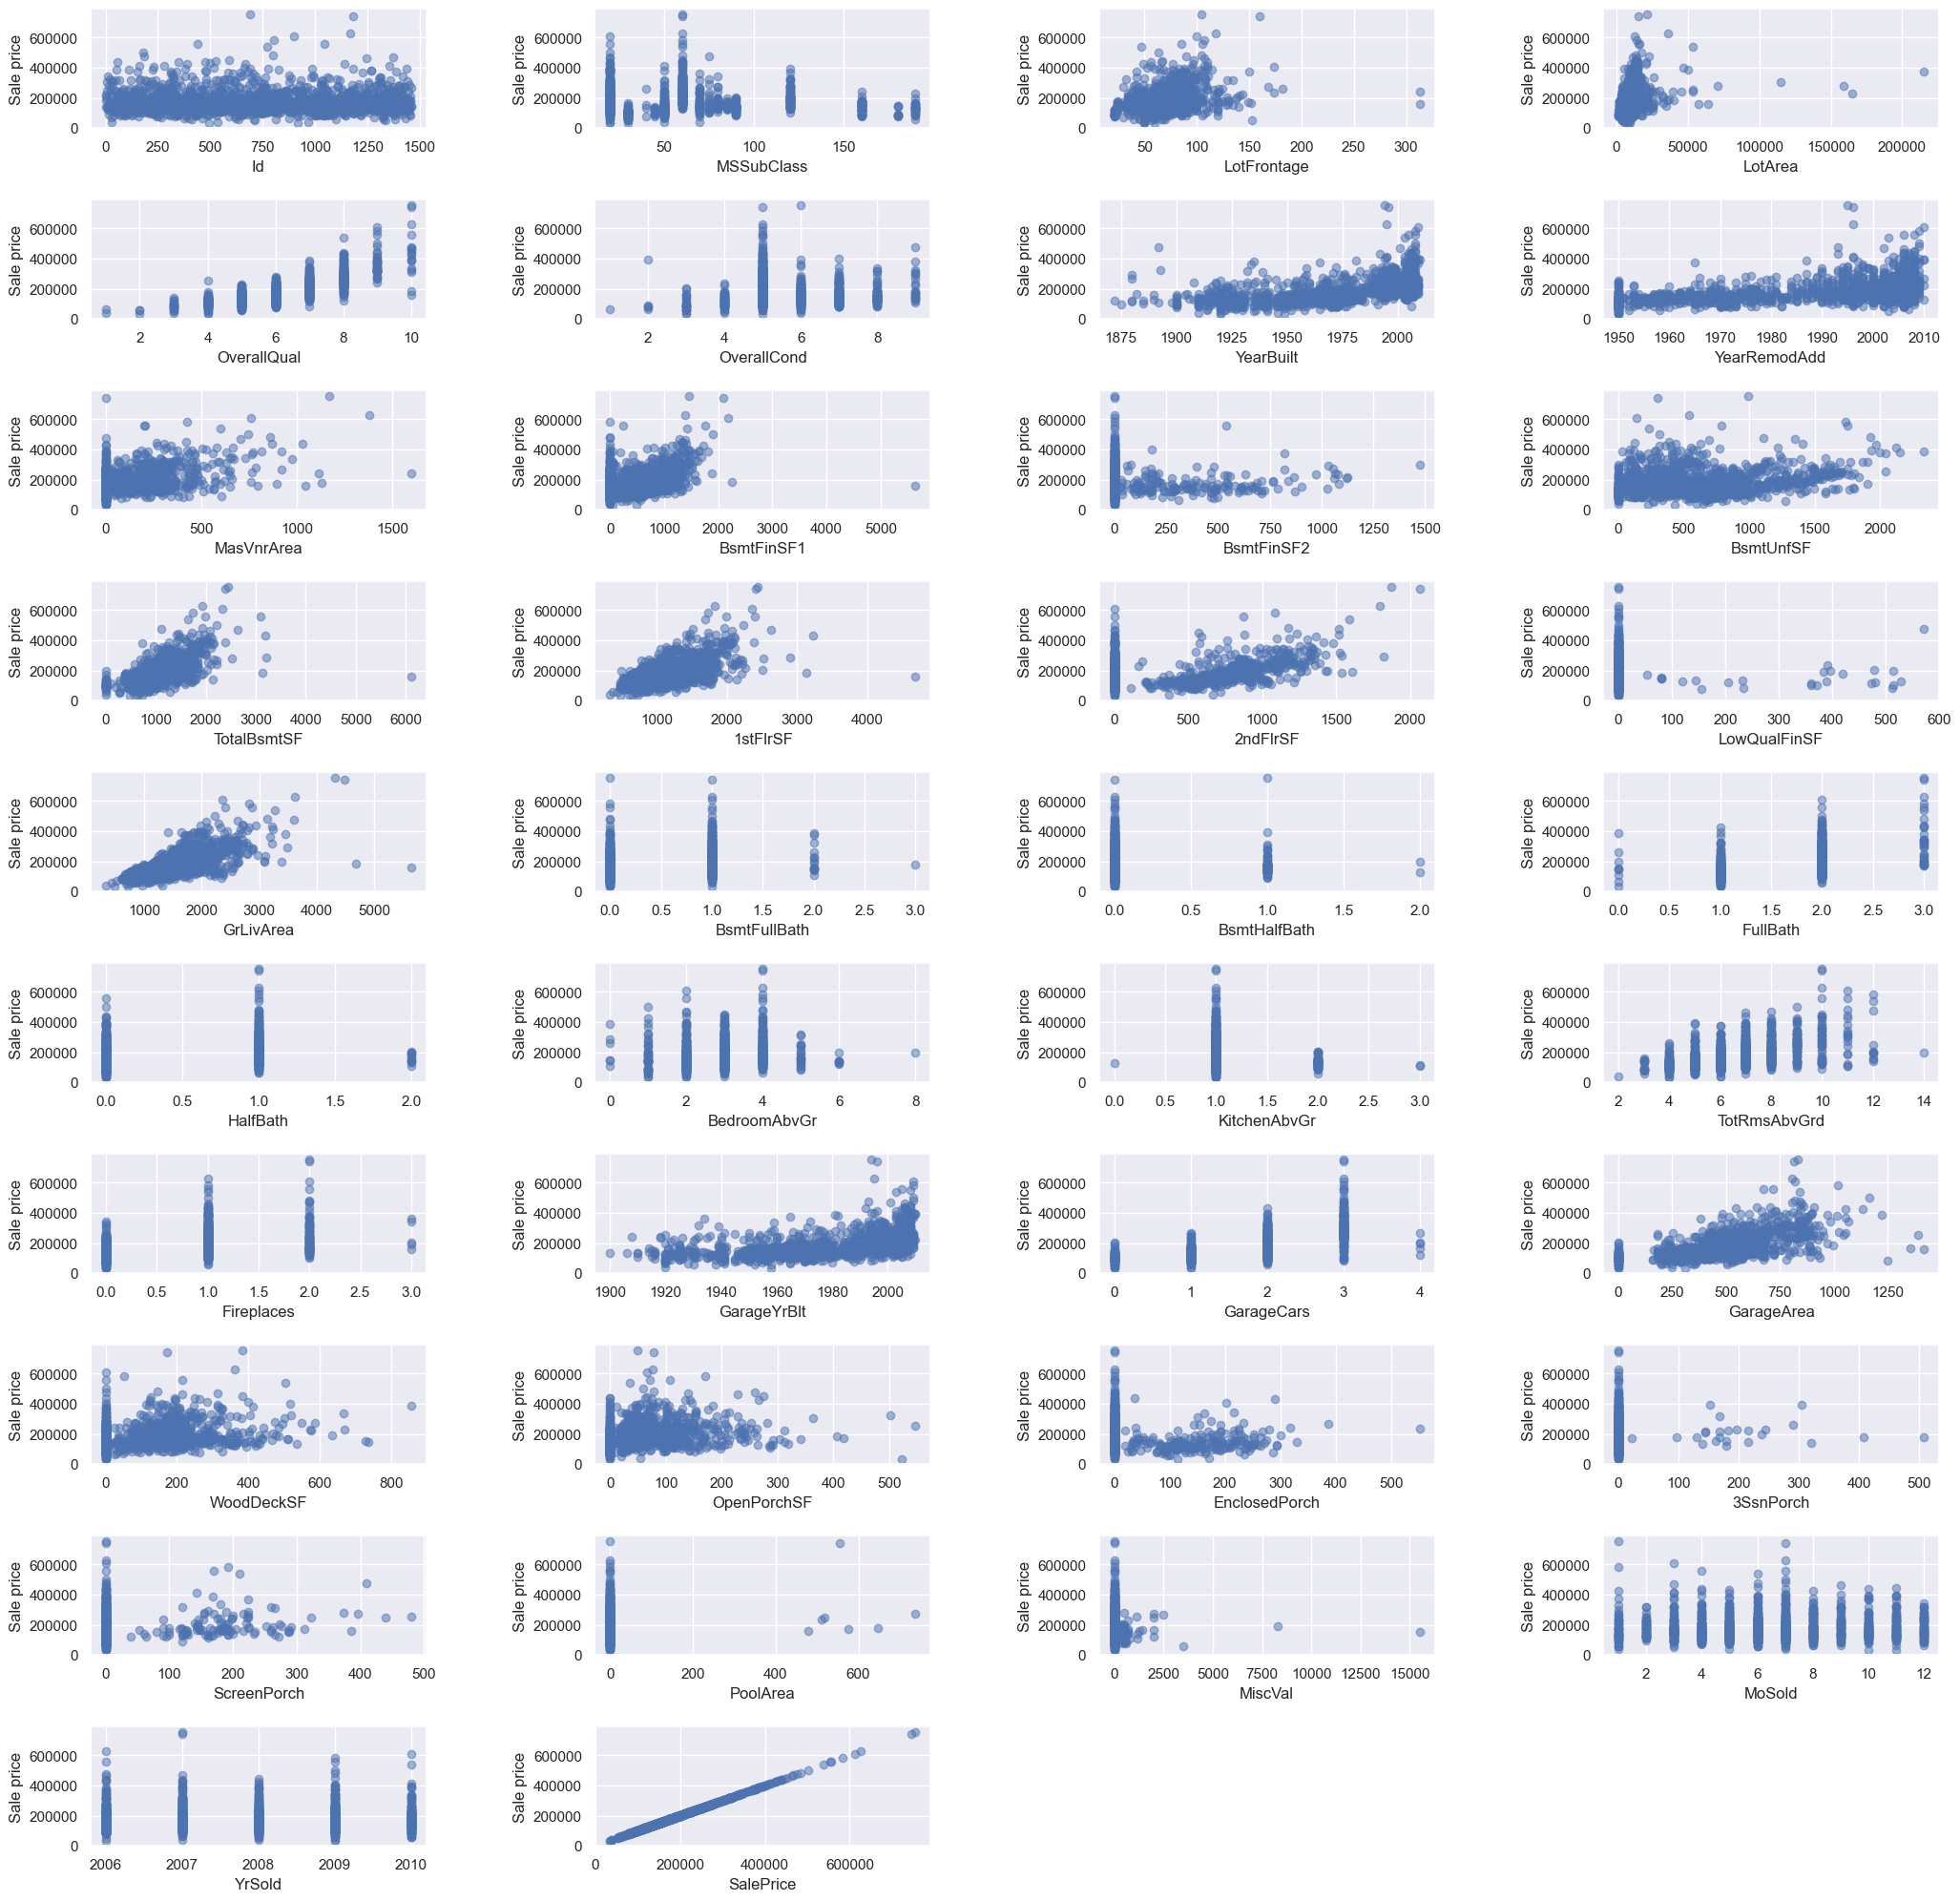

In [18]:
scatterplots(features, ncol=4, figsize=(25, 25))

Besides the top 10 features listed previously, this scatter plot also gives us a reasonable idea about variables relationships on some other features:

Features that are positive correlated with `SalePrice`:
- `LotFrontage`, `GarageArea`
- Some of the time related feature seem positive correlated, we will dive deeper using line plot next: `GarageYrBlt`, `YearRemodAdd`, `GarageYrBlt`, `MoSold`


### Let's also take a look of histgorm of numeric features 


In [19]:
# Define useful function to create scatterplots of sale prices against desired columns
def histplots(columns, ncol=None, figsize=(25, 25)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=1)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.hist(x = col, data=df_train, alpha=0.5)
        ax.set(title='Distribution of ' + col)
        ax.set(xlabel=col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

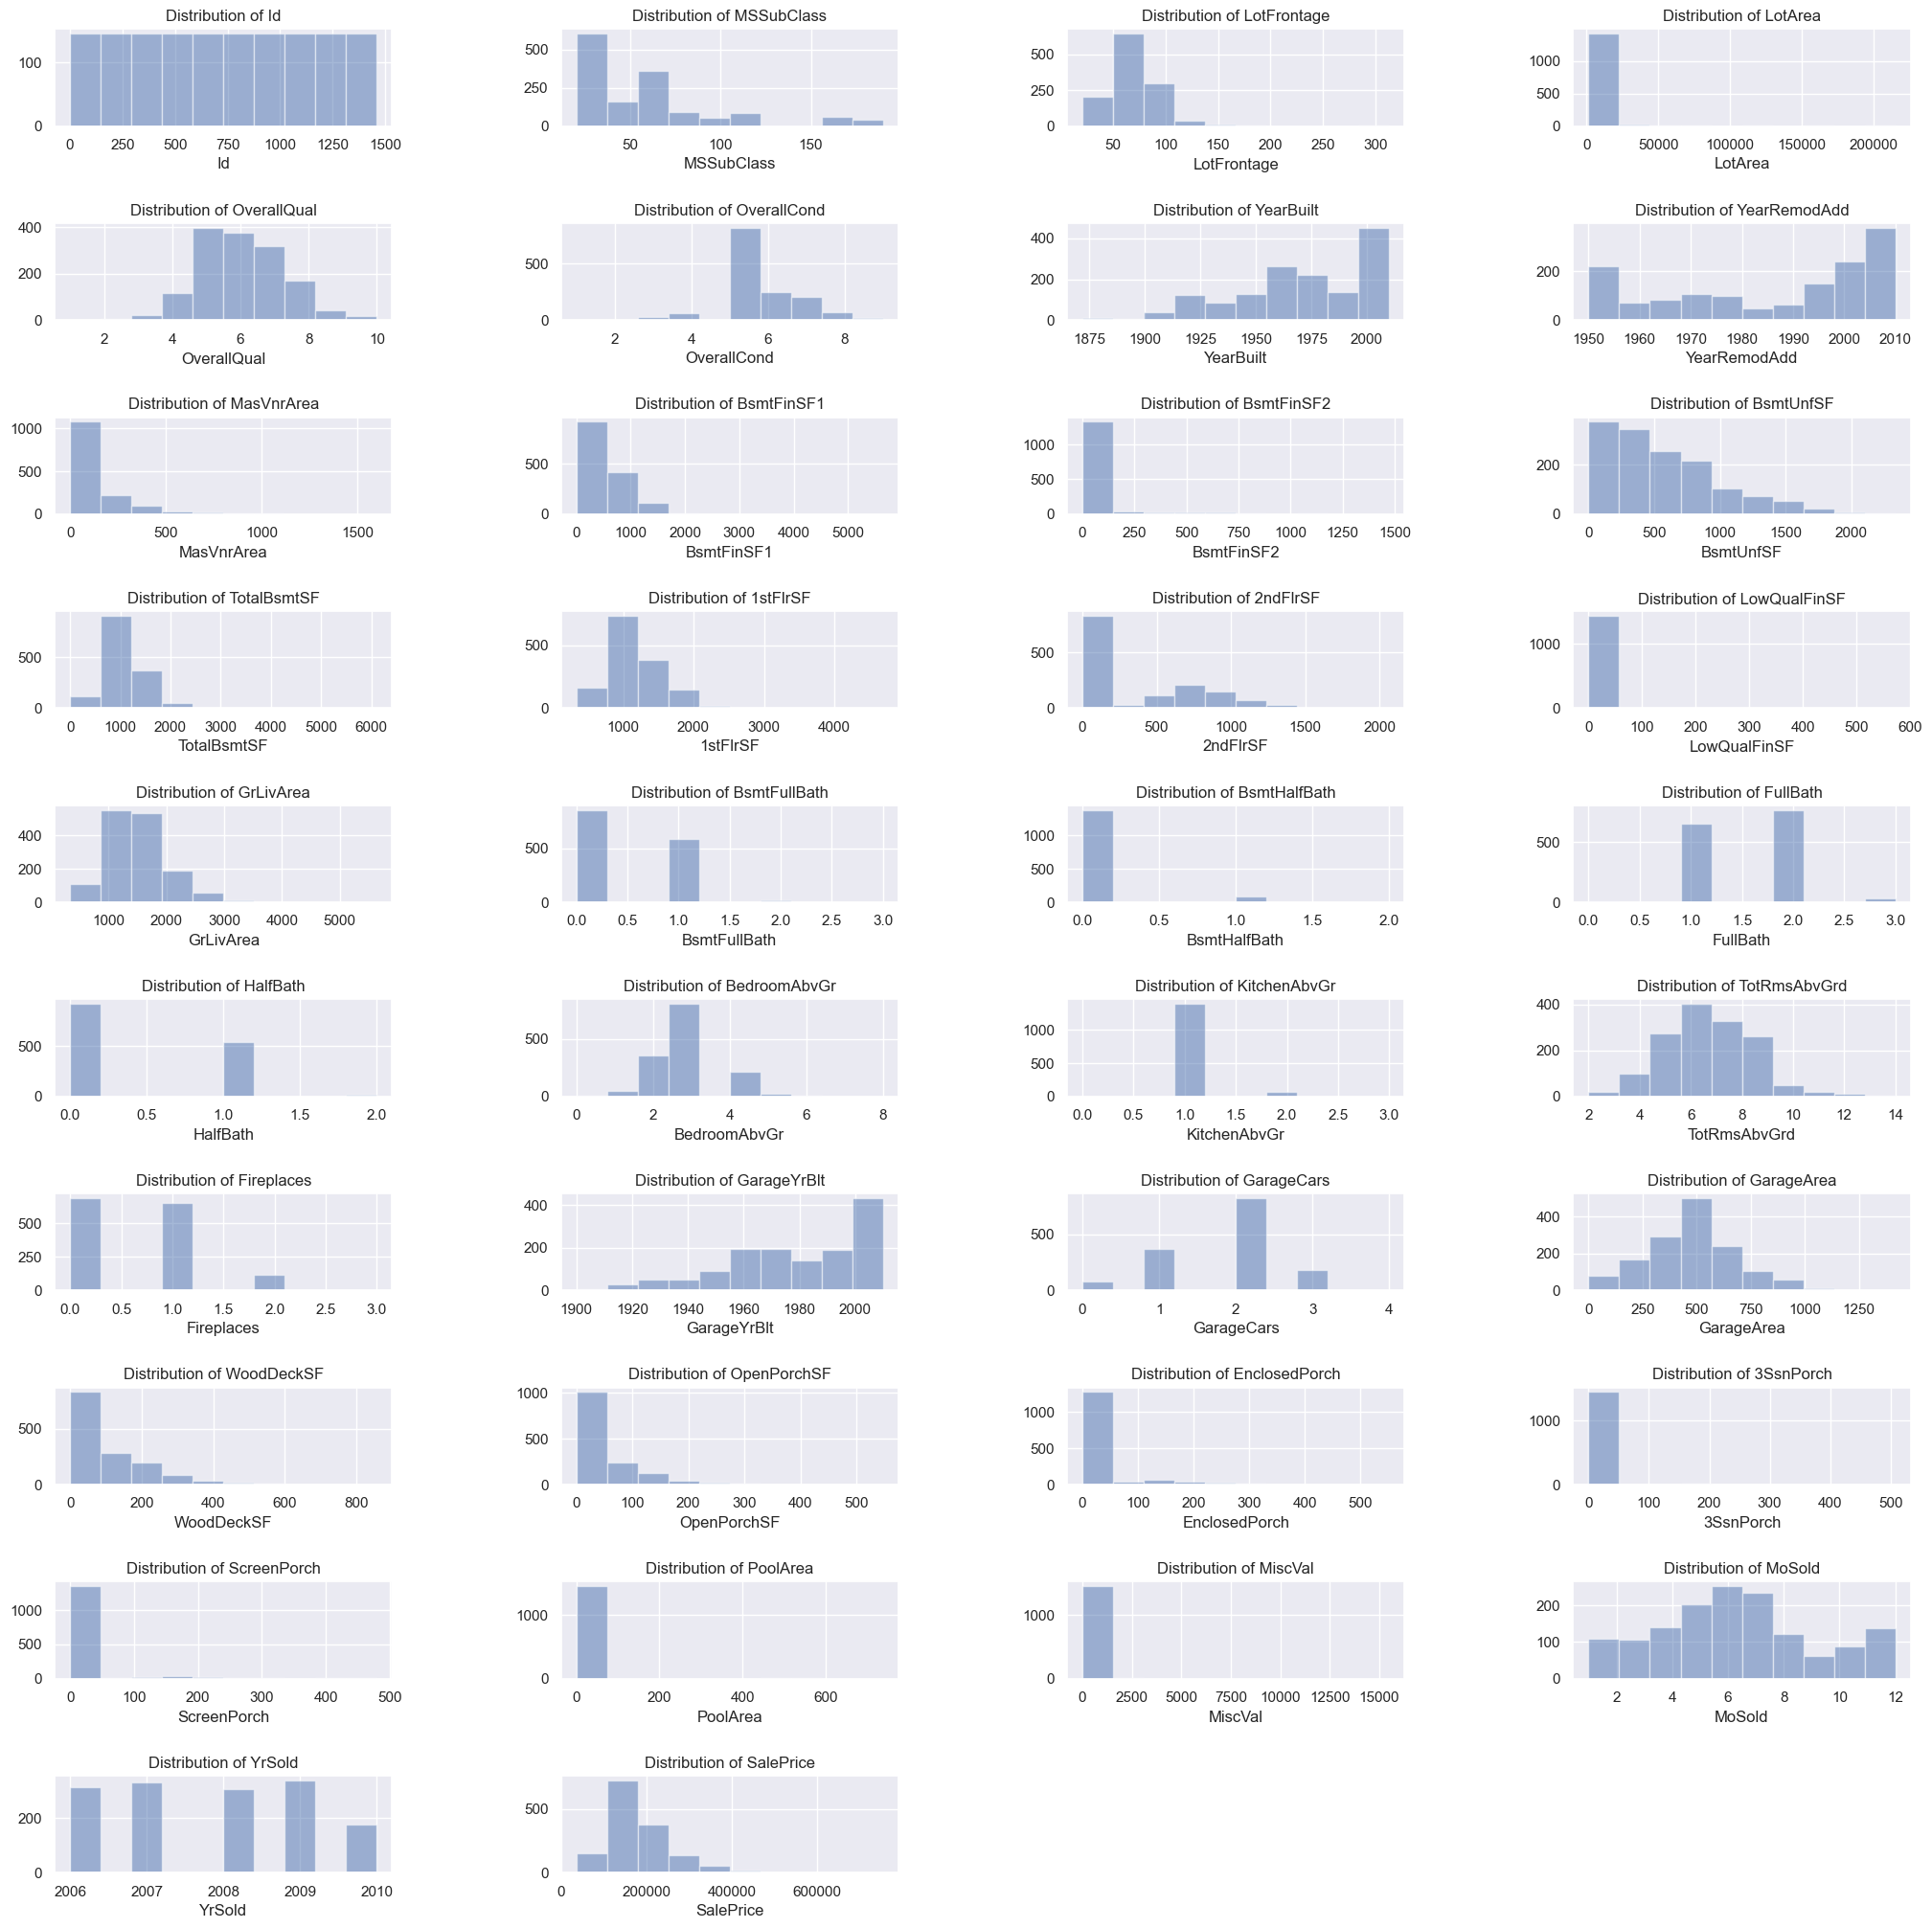

In [20]:
histplots(features, ncol=4, figsize=(25, 25))

Some features that I found interesting in are:
- `TotRmsAbvGrd`: majority of houses come with 5-8 rooms
- `HalfBath`: most of houses don't come with half bath
- `GarageArea`: majority of houses has 500 sqft
- `GarageYrBlt`: most of houses has garage built in year 2000
- `GrLivArea`: majority of houses has 1000-2000 sqft living area above ground
- `EnclosedPorch`: most of houses don't have enclosed porch area
- `3SsnPorch`: most of houses don't have three season porch area which is not surprising due to the above observation
- `PoolArea`: almost no houses has pool area!

### Line plot of Time Related Features Against Sale Price

<AxesSubplot:xlabel='MoSold', ylabel='SalePrice'>

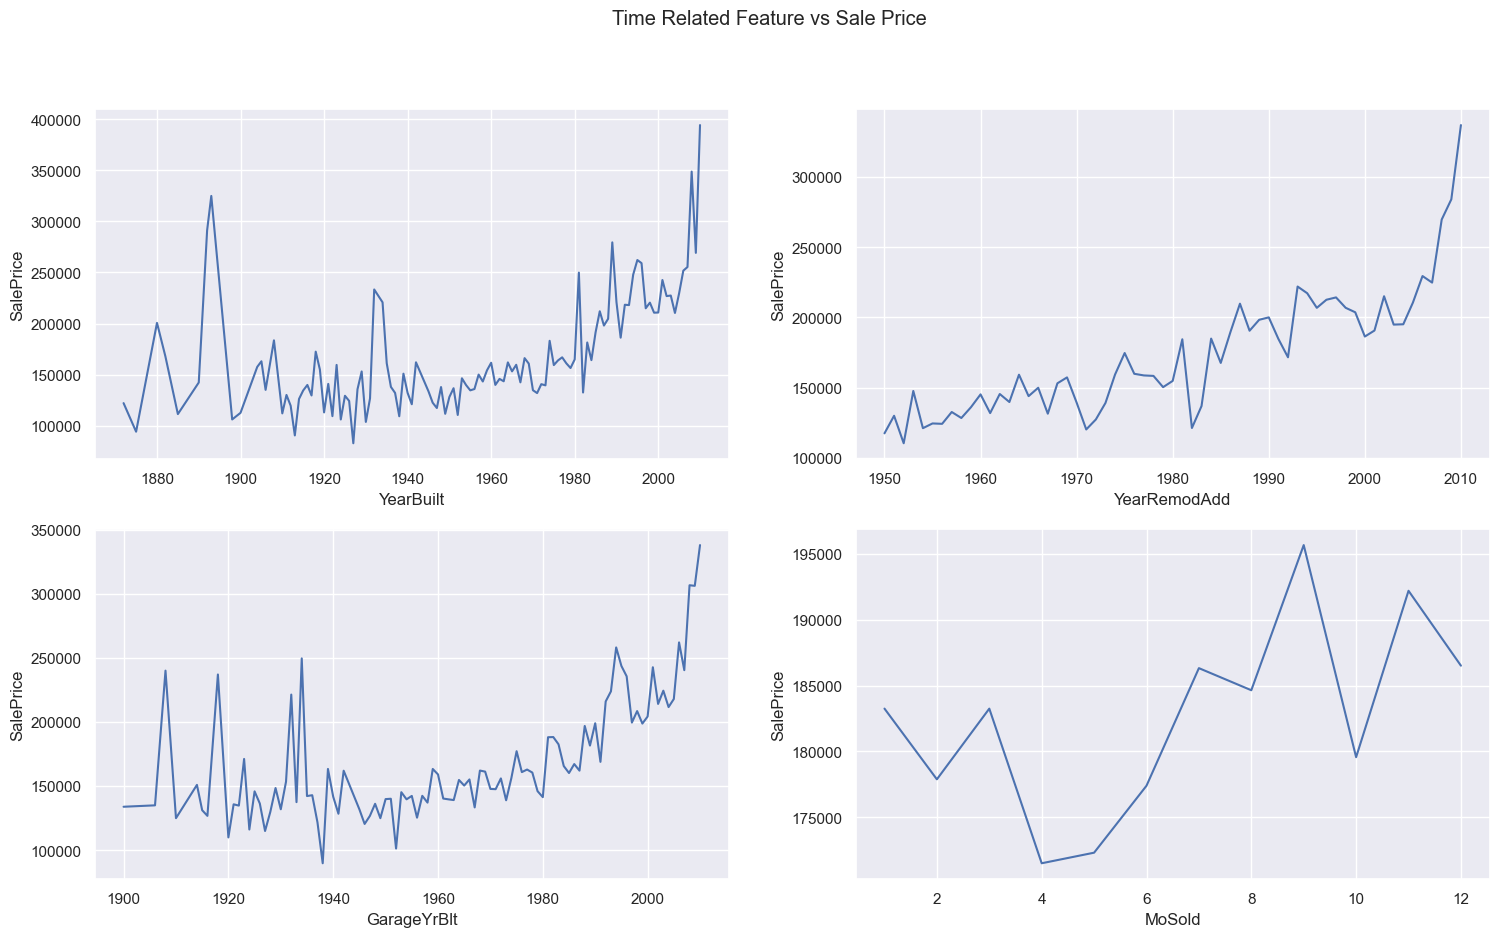

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Time Related Feature vs Sale Price')

sns.lineplot(ax=axes[0, 0], data=df_train, x='YearBuilt', y='SalePrice', ci=None)
sns.lineplot(ax=axes[0, 1], data=df_train, x='YearRemodAdd', y='SalePrice', ci=None)
sns.lineplot(ax=axes[1, 0], data=df_train, x='GarageYrBlt', y='SalePrice', ci=None)
sns.lineplot(ax=axes[1, 1], data=df_train, x='MoSold', y='SalePrice', ci=None)


- In general, the more recent the propery was built or remodeled, the more expensive it is
- We can also see SalePrice is higher in the second half of the year

### Let's explore categorical features vs Sale Price

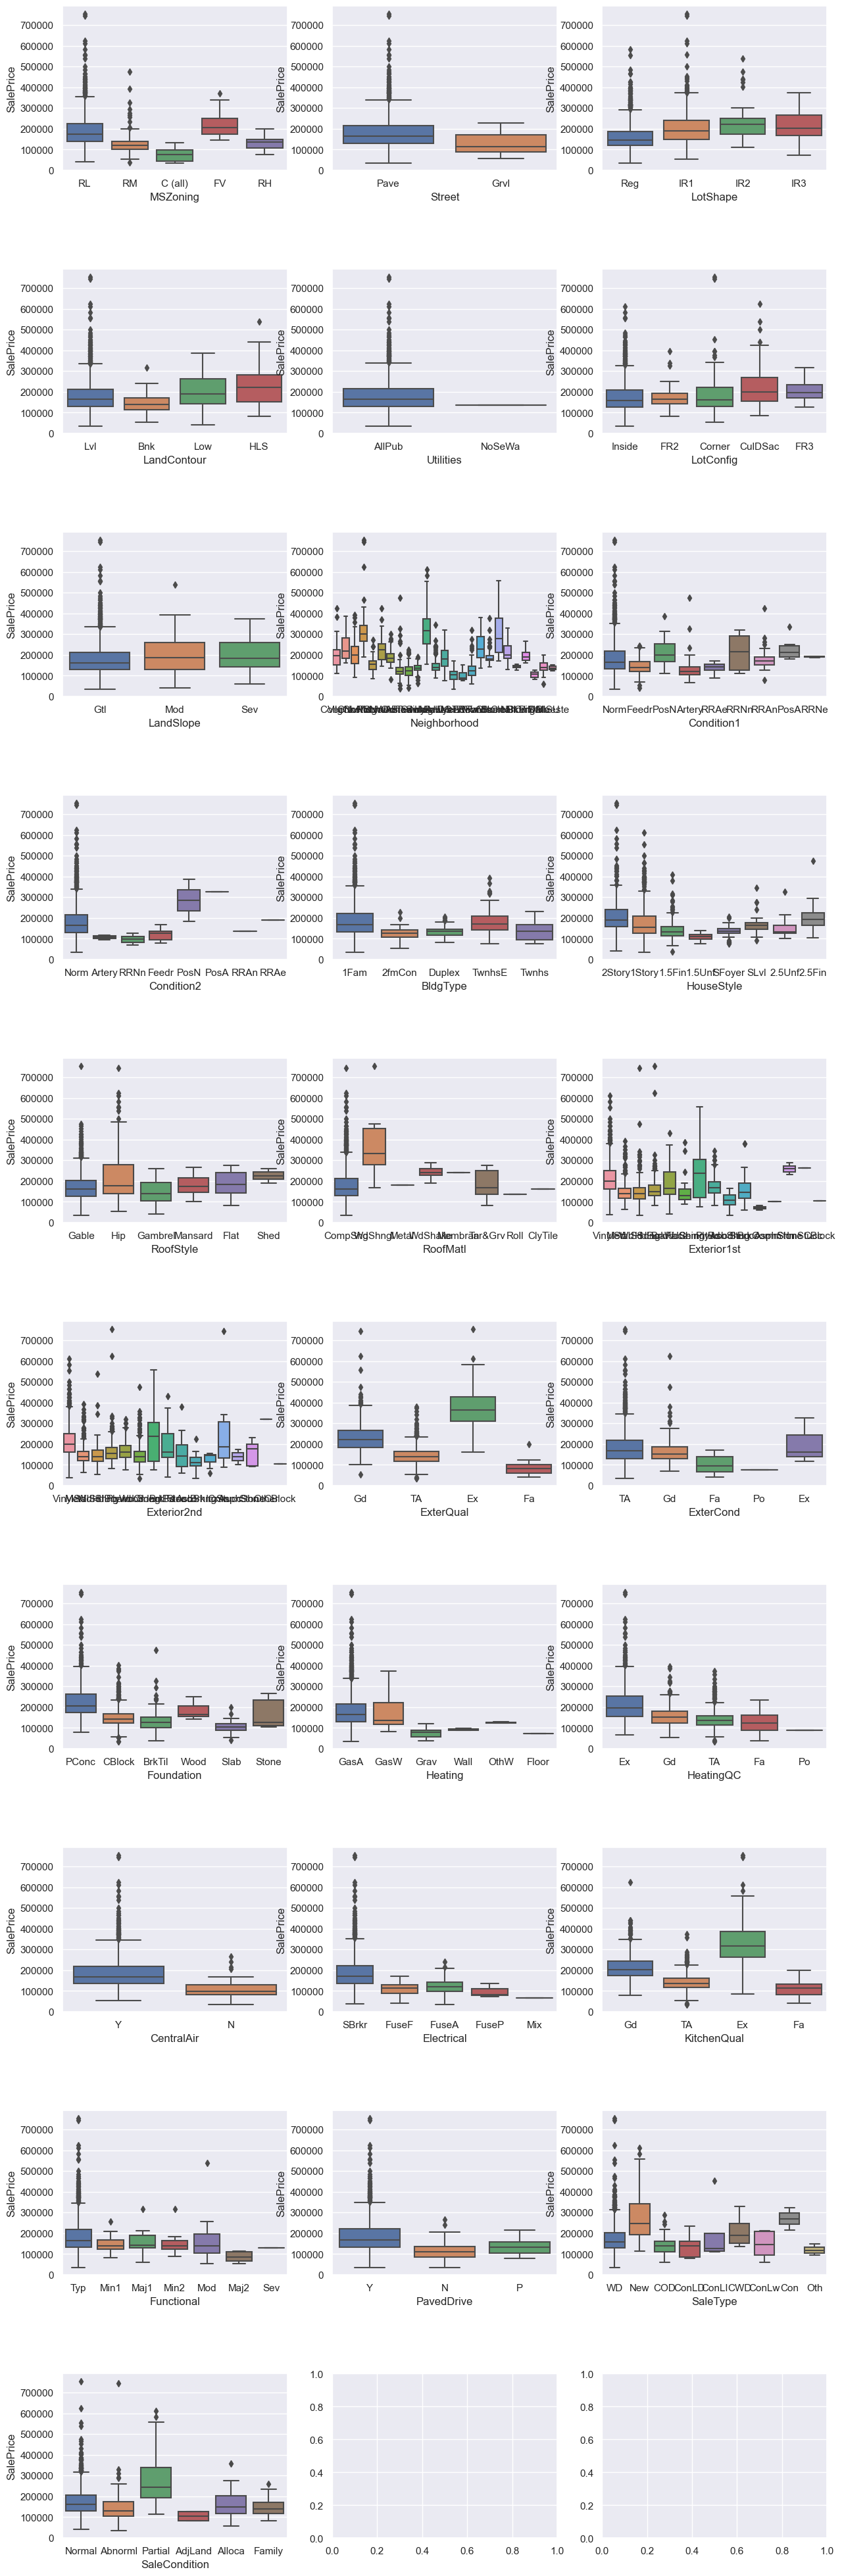

In [36]:
ncols = 3
nrows = int(np.ceil(len(df_train.select_dtypes(include='object').columns) / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), squeeze=False)
axs = axs.flatten()

for i, col in enumerate(df_train.select_dtypes(include='object').columns):
    if i < len(axs):
        sns.boxplot(x=df_train[col], y=df_train['SalePrice'], data=df_train, ax=axs[i])

fig.subplots_adjust(hspace=0.6)
plt.show()

From the boxplots above, some of the significant categorical attributes are:
- `ExterQual`: Properties with excellent or good quality tend to be more expensive.
- Other significant attributes: `PoolQC`, `KitchenQual`, `BsmtQual`, `GarageFinish`, `MasVnrType`, `Foundation`, etc.

### Missing data

Let's also check out features that has missing data and how it's relevent to Sale Price

In [30]:
# Checking for null values
missing = pd.concat([df_train.isnull().sum(), 100 * df_train.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing[missing['count']>0].sort_values(by='count', ascending=False)

,count,%
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945


- Normally, we should consider deleting the variables when the data is missing more than 15%. 

- The features are `PoolQC`, `MiscFeature`, `Alley`, `FireplaceQu`. None of these variables seem to be very important, since most of them are not aspects in which we think about when buying a house. Moreover, looking closer at the variables, we could say those variables are strong candidates for outliers, it's fine to delete them.

- `GarageX` variables: they have the same number of missing data. Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, I'll delete `GarageX` variables. The same logic applies to 'BsmtX' variables.

- Regarding `MasVnrArea` and `MasVnrType`, we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.

- Finally, we have one missing observation in 'Electrical'. Since it is just one observation, I'll delete this observation and keep the variable.

- In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data.

In [31]:
#dealing with missing data
df_train = df_train.drop((missing[missing['count'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

/var/folders/3t/zg2pg4h96j33j992z6f26cgh0000gn/T/ipykernel_75849/1629297489.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_train = df_train.drop((missing[missing['count'] > 1]).index,1)


In [32]:
df_train.isnull().any().sum()

0